<a href="https://colab.research.google.com/github/BoundlessDomain/2025NTU-IntroToDataScienceAndAI/blob/main/IntroToDataScienceAndAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Place holder main title

---

Dataset from Our World in Data: "**Energy**" by *Hannah Ritchie, Pablo Rosado, and Max Roser (2023)*

Source: [Our World in Data - Energy](https://ourworldindata.org/energy)

In [24]:
# Essential libraries
import numpy as np # Library for Numeric Computations in Python.
import pandas as pd # Library for Data Acquisition and Preparation.
import matplotlib.pyplot as plt # Low-level library for Data Visualization.
import seaborn as sb # Higher-level library for Data Visualization.
sb.set() # Set the default Seaborn style for graphics.
import plotly.graph_objects as go # Imported for Sankey diagram.
from sklearn.cluster import KMeans

In [25]:
# Import the dataset
world_energy_data = pd.read_csv('/content/owid-energy-data.csv')
world_energy_data.head()

,country,year,iso_code,population,gdp,biofuel_cons_change_pct,biofuel_cons_change_twh,biofuel_cons_per_capita,biofuel_consumption,biofuel_elec_per_capita,...,solar_share_elec,solar_share_energy,wind_cons_change_pct,wind_cons_change_twh,wind_consumption,wind_elec_per_capita,wind_electricity,wind_energy_per_capita,wind_share_elec,wind_share_energy
0,ASEAN (Ember),2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN
1,ASEAN (Ember),2001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN
2,ASEAN (Ember),2002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN
3,ASEAN (Ember),2003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN
4,ASEAN (Ember),2004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN


In [26]:
# Dataset statistics.
print("Data type : ", type(world_energy_data))
print("Data dims : ", world_energy_data.shape)
print(world_energy_data.dtypes)

Data type :  <class 'pandas.core.frame.DataFrame'>
Data dims :  (21975, 130)
country                    object
year                        int64
iso_code                   object
population                float64
gdp                       float64
                           ...   
wind_elec_per_capita      float64
wind_electricity          float64
wind_energy_per_capita    float64
wind_share_elec           float64
wind_share_energy         float64
Length: 130, dtype: object


# Part 1 - Data cleaning

In [27]:
# 1. Extract data in the time range of 1990 to 2022.
# We are starting from 1900 to ensure we have the more recent relevant data for the problem since pre 1990, world renewable energy generation has not started yet.
# We use data up to 2022 to ensure we have a more complete dataset to work with since official records are frequently a few years behind, and including them would lead to lots of null data.
year_filtered_world_energy_data = world_energy_data[(world_energy_data['year'] >= 1990) & (world_energy_data['year'] <= 2022)]
print(f"Data shape after filtering for years 1990-2022: {year_filtered_world_energy_data.shape}")

Data shape after filtering for years 1990-2022: (9227, 130)


In [28]:
# 2. Extract only countries in the time range of 1990 to 2022.
# Since the dataset contains data from many sources on both countries, continents, political groupings etc. we need to extract only countries for processing.
only_country_year_filtered_world_energy_data = year_filtered_world_energy_data.dropna(subset=['iso_code'])
print(f"Data shape after removing non-country aggregates: {only_country_year_filtered_world_energy_data.shape}")

Data shape after removing non-country aggregates: (7181, 130)


In [29]:
# 3. For countries missing sections of data on energy consumption, gdp, and population, we will perform country specific linear interpolation.
# 3.a. Identify the columns which need interpolation and the columns to keep.
consumption_columns = [column for column in only_country_year_filtered_world_energy_data.columns if '_consumption' in column] # Holds a list of all of the column names which have "_consumption".
columns_to_keep = ['country', 'year', 'iso_code', 'gdp', 'population'] + consumption_columns
columns_to_interpolate = ['gdp', 'population'] + consumption_columns

# 3.b. Filter the dataframe to keep only the desired columns.
column_removed_only_country_year_filtered_world_energy_data = only_country_year_filtered_world_energy_data[columns_to_keep]

# 3.c. Group the data to interpolate by country, and interpolate by each group's time series.
for column in columns_to_interpolate: # This loops through every column named previously on the columns which need interpolation.
    if column in column_removed_only_country_year_filtered_world_energy_data.columns:
      # .loc used to select rows and columns by label, : used to select all rows, column used to select in the columns with a specific name
      # Groups data by country, calculate the interpolated values for the current column for each countries time series, and reassembles back into a single column.
        column_removed_only_country_year_filtered_world_energy_data.loc[:, column] = column_removed_only_country_year_filtered_world_energy_data.groupby('country')[column].transform(
            lambda x: x.interpolate(method='linear', limit_direction = 'both') # x.interpolate fills in the missing values using a straight (linear) line with known data points, and try to fill in missing beginning or end values of a country.
            )


# 3.d. After interpolation, for countries with remaining NaN values, remove these values.
cleaned_world_energy_data = column_removed_only_country_year_filtered_world_energy_data.dropna(subset = columns_to_interpolate) # Removes rows only with NaN values in the listed columns to interpolate earlier.

print(f"Data shape after interpolation and removing NaN values: {cleaned_world_energy_data.shape}")

Data shape after interpolation and removing NaN values: (1914, 18)


In [30]:
cleaned_world_energy_data

,country,year,iso_code,gdp,population,biofuel_consumption,coal_consumption,fossil_fuel_consumption,gas_consumption,hydro_consumption,low_carbon_consumption,nuclear_consumption,oil_consumption,other_renewable_consumption,primary_energy_consumption,renewables_consumption,solar_consumption,wind_consumption
1108,Argentina,1990,ARG,3.387512e+11,32755859.0,5.923,12.266,439.559,197.320,52.378,73.462,20.660,229.973,0.425,513.022,52.802,0.000,0.000
1109,Argentina,1991,ARG,3.760579e+11,33230247.0,5.923,10.794,451.996,200.919,46.925,69.351,22.008,240.283,0.418,521.347,47.343,0.000,0.000
1110,Argentina,1992,ARG,4.166798e+11,33693487.0,5.923,12.168,482.131,217.257,56.671,77.178,20.092,252.706,0.415,559.309,57.086,0.000,0.000
1111,Argentina,1993,ARG,4.447802e+11,34152666.0,5.923,8.070,485.263,229.413,70.283,92.580,21.991,247.780,0.306,577.843,70.589,0.000,0.000
1112,Argentina,1994,ARG,4.729267e+11,34613440.0,5.923,7.065,504.392,235.831,80.686,104.369,23.367,261.495,0.316,608.761,81.002,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20644,United States,2018,USA,1.812469e+13,335056439.0,404.621,3689.459,22212.854,8219.633,765.977,4556.134,2156.894,10303.763,250.438,26768.988,2399.240,249.513,728.691
20645,United States,2019,USA,1.854055e+13,337790020.0,415.870,3150.460,21948.143,8509.999,752.485,4630.352,2155.132,10287.684,234.433,26578.494,2475.220,284.616,787.816
20646,United States,2020,USA,1.802736e+13,339436106.0,378.321,2556.181,19936.998,8345.496,742.663,4685.650,2095.404,9035.320,225.994,24622.648,2590.245,346.779,896.488
20647,United States,2021,USA,1.909938e+13,340161392.0,415.839,2936.894,21170.129,8364.249,651.455,4786.699,2060.685,9868.985,224.519,25956.828,2726.014,434.585,999.615


In [31]:
# Visualisation of number of data dropped through each step of the cleaning process.

# Get the row counts at each stage of the cleaning process.
initial_count = world_energy_data.shape[0]
year_filtered_count = year_filtered_world_energy_data.shape[0]
country_filtered_count = only_country_year_filtered_world_energy_data.shape[0]
final_cleaned_count = cleaned_world_energy_data.shape[0]

# Calculate the number of rows that were removed at each stage.
removed_by_year_filter = initial_count - year_filtered_count
removed_by_country_filter = year_filtered_count - country_filtered_count
removed_by_nan_drop = country_filtered_count - final_cleaned_count

# Define the nodes of the Sankey diagram.
# Each node is a stage in the cleaning process or a set of removed data.
labels = [
    f"Initial Dataset<br>({initial_count:,} rows)", # Node 0
    f"1. Filtered by Year<br>({year_filtered_count:,} rows)", # Node 1
    f"2. Filtered for Countries<br>({country_filtered_count:,} rows)", # Node 2
    f"Final Cleaned Data<br>({final_cleaned_count:,} rows)", # Node 3
    f"Removed by Year Filter<br>({removed_by_year_filter:,} rows)", # Node 4
    f"Removed by Country Filter<br>({removed_by_country_filter:,} rows)", # Node 5
    f"Removed by NaN Drop<br>({removed_by_nan_drop:,} rows)" # Node 6
]

# Define the links between the nodes.
fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 25,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = labels,
      x = [0.01, 0.33, 0.66, 0.99, 0.33, 0.66, 0.99],
      y = [0.5, 0.2, 0.3, 0.7, 0.8, 0.5, 0.4],
      color = ["#4c78a8", "#f58518", "#e45756", "#72b7b2", "#54a24b", "#eeca3b", "#b279a2"]
    ),
    link = dict(
      source = [0, 0, 1, 1, 2, 2], # Indices of the source nodes.
      target = [1, 4, 2, 5, 3, 6], # Indices of the target nodes.
      value = [
          year_filtered_count, removed_by_year_filter,
          country_filtered_count, removed_by_country_filter,
          final_cleaned_count, removed_by_nan_drop
      ]
  ))])

fig.update_layout(
    title_text="Data Reduction Through Cleaning"
)

fig.show()

# Part 2 - Clustering countries by economic groups

In [32]:
# 1. Calculate GDP per Capita for every country.
cleaned_world_energy_data['gdp_per_capita'] = cleaned_world_energy_data['gdp'] / cleaned_world_energy_data['population']
cleaned_world_energy_data.head()

/tmp/ipython-input-32-77511501.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,country,year,iso_code,gdp,population,biofuel_consumption,coal_consumption,fossil_fuel_consumption,gas_consumption,hydro_consumption,low_carbon_consumption,nuclear_consumption,oil_consumption,other_renewable_consumption,primary_energy_consumption,renewables_consumption,solar_consumption,wind_consumption,gdp_per_capita
1108,Argentina,1990,ARG,3.387512e+11,32755859.0,5.923,12.266,439.559,197.320,52.378,73.462,20.660,229.973,0.425,513.022,52.802,0.0,0.0,10341.696743
1109,Argentina,1991,ARG,3.760579e+11,33230247.0,5.923,10.794,451.996,200.919,46.925,69.351,22.008,240.283,0.418,521.347,47.343,0.0,0.0,11316.735670
1110,Argentina,1992,ARG,4.166798e+11,33693487.0,5.923,12.168,482.131,217.257,56.671,77.178,20.092,252.706,0.415,559.309,57.086,0.0,0.0,12366.776443
1111,Argentina,1993,ARG,4.447802e+11,34152666.0,5.923,8.070,485.263,229.413,70.283,92.580,21.991,247.780,0.306,577.843,70.589,0.0,0.0,13023.295139
1112,Argentina,1994,ARG,4.729267e+11,34613440.0,5.923,7.065,504.392,235.831,80.686,104.369,23.367,261.495,0.316,608.761,81.002,0.0,0.0,13663.095857


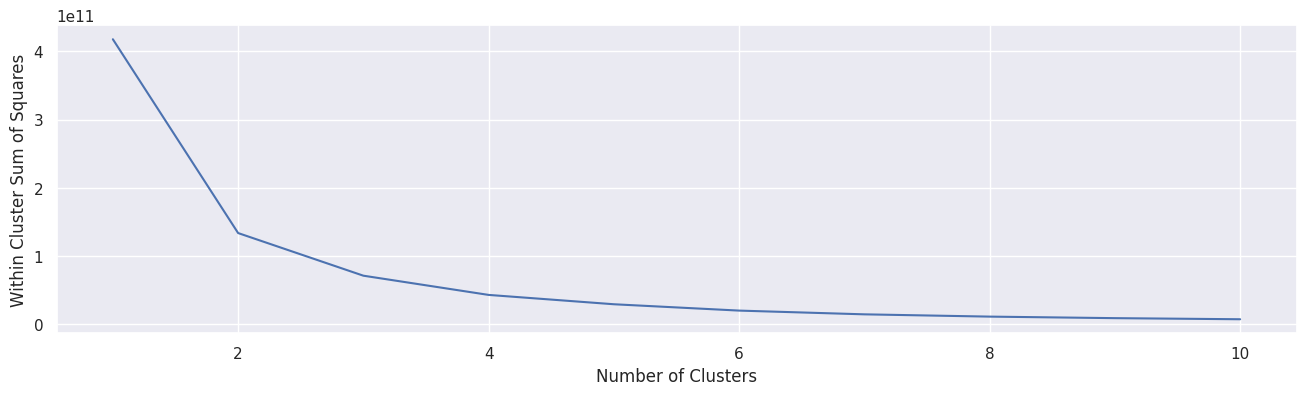

In [33]:
# 2. Find optimal number of clusters for the data.
# Create a new Data Frame for only gpd per capita data and remove NaN values.
gdp_per_capita_data = cleaned_world_energy_data[['gdp_per_capita']].dropna()

# Set the range of number of clusters.
minimum_clusters = 1
maximum_clusters = 10

# Compute within cluster sum of squares.
within_ss = []
for num_clust in range(minimum_clusters, maximum_clusters + 1):
    kmeans = KMeans(n_clusters=num_clust, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(gdp_per_capita_data)
    within_ss.append(kmeans.inertia_)

# Plot sum of squared errors graph.
f, axes = plt.subplots(1, 1, figsize=(16,4))
plt.plot(range(minimum_clusters, maximum_clusters+1), within_ss)
plt.xlabel('Number of Clusters')
plt.ylabel('Within Cluster Sum of Squares')
plt.show()

In [34]:
# 3. Clustering model.
number_of_clusters = 4

# init='k-means++' for placing starting points for clusters far apart, random_state=42 for making clustering repeatable, n_init=10 for running algorithms 10 times and selecting the best outcome.
kmeans = KMeans(n_clusters=number_of_clusters, init='k-means++', random_state=42, n_init=10)
kmeans.fit(gdp_per_capita_data) # Fit the clustering model onto the data.

# Print the cluster centers.
for i, center in enumerate(kmeans.cluster_centers_):
    print("Cluster", i, end=":\t")
    for coord in center:
        print(round(coord, 2), end="\t")
    print()
print()

# Print the within cluster sum of squares.
print(f"Within cluster sum of squares (Inertia) for k = {number_of_clusters}: {kmeans.inertia_:,.2f}")
print()

# Use trained model to predict cluster for each data point.
labels = kmeans.predict(gdp_per_capita_data)

# Create a new data frame to hold the data and new cluster labels.
gdp_per_capita_data_labeled = gdp_per_capita_data.copy()
gdp_per_capita_data_labeled["Cluster"] = pd.Categorical(labels)

# Add labelled data to main data frame for later useage.
cleaned_world_energy_data.loc[gdp_per_capita_data.index, 'gdp_cluster'] = labels

print(cleaned_world_energy_data[['country', 'year', 'gdp_per_capita', 'gdp_cluster']].head())

Cluster 0:	38757.21	
Cluster 1:	10265.74	
Cluster 2:	24443.37	
Cluster 3:	58580.47	

Within cluster sum of squares (Inertia) for k = 4: 42,308,283,322.74

        country  year  gdp_per_capita  gdp_cluster
1108  Argentina  1990    10341.696743          1.0
1109  Argentina  1991    11316.735670          1.0
1110  Argentina  1992    12366.776443          1.0
1111  Argentina  1993    13023.295139          1.0
1112  Argentina  1994    13663.095857          1.0


/tmp/ipython-input-34-1559581904.py:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



/tmp/ipython-input-35-105166591.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-35-105166591.py:11: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




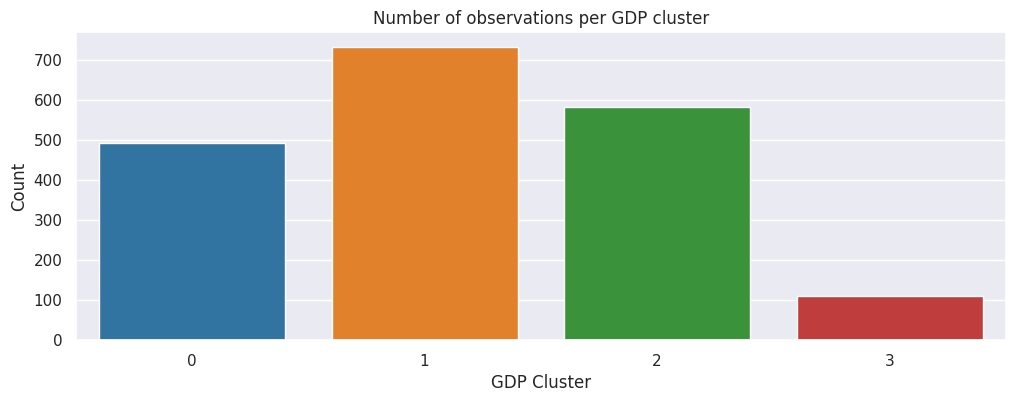

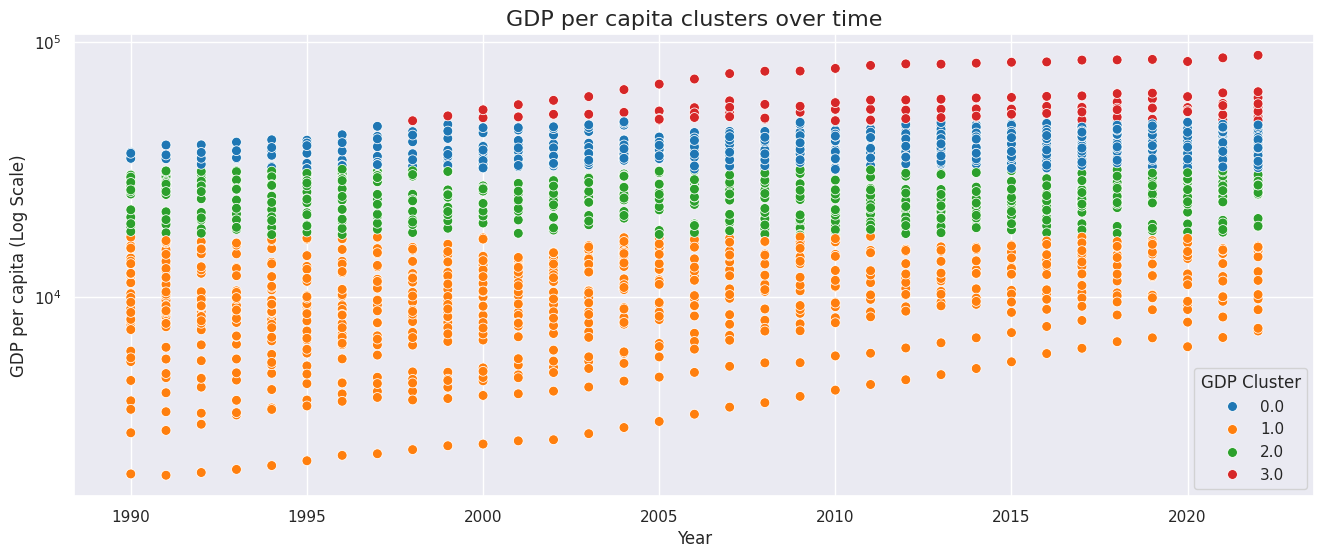

In [35]:
# 4. Visualise the clustered data.

# Convert the 'gdp_cluster' column to a categorical type for consistent coloring.
cleaned_world_energy_data['gdp_cluster'] = cleaned_world_energy_data['gdp_cluster'].astype('category')
gdp_per_capita_data_labeled['Cluster'] = gdp_per_capita_data_labeled['Cluster'].astype('category')
# Define a color palette with more contrast for the clusters.
cluster_palette = 'tab10'

# Countplot of observations per cluster.
plt.figure(figsize=(12, 4))
sb.countplot(x=gdp_per_capita_data_labeled["Cluster"], palette=cluster_palette)
plt.title('Number of observations per GDP cluster')
plt.xlabel('GDP Cluster')
plt.ylabel('Count')
plt.show()

# Scatterplot of GDP per capita clusters over time.
fig, axes = plt.subplots(1, 1, figsize=(16, 6))
sb.scatterplot(data=cleaned_world_energy_data.dropna(subset=['gdp_cluster']), x='year', y='gdp_per_capita', hue='gdp_cluster', palette=cluster_palette, s=50, ax=axes)
axes.set_title('GDP per capita clusters over time', fontsize=16)
axes.set_xlabel('Year', fontsize=12)
axes.set_ylabel('GDP per capita (Log Scale)', fontsize=12)
axes.set_yscale('log')
axes.legend(title='GDP Cluster')
axes.grid(True)
plt.show()

# Part 3 - Energy diversity analysis

Extracting the relevant columns for the energy diversity analysis. After some preliminary analysis, the column prefixes `fossil_`, `low_carbon_`, and `renewables_` have been identified as aggregates (i.e. the sum of other columns), so we will skip those. We will also skip `biofuel_` and use `other_renewables_` instead since it seems to make the data cleaner. We want to analyse electricity generation percentage which is given by the `_share_elec` suffix, so we will only pull those columns.

In [36]:
unwanted_col_prefixes = ("fossil_", "low_carbon_", "renewables_", "biofuel_")
share_elec_cols = [col for col in world_energy_data.columns if col.endswith("_share_elec") and not col.startswith(unwanted_col_prefixes)]
share_elec_cols

['coal_share_elec',
 'gas_share_elec',
 'hydro_share_elec',
 'nuclear_share_elec',
 'oil_share_elec',
 'other_renewables_share_elec',
 'solar_share_elec',
 'wind_share_elec']

Next, we want to keep the country, year, population, and GDP columns, but we should drop any missing values in those columns. This includes dropping any rows with missing `iso_code` because we only want to deal with countries, not continents/regions. Finally, we will make a `share_elec_sum` column which is the sum of all the electricity generation percentages. There will be some variation in the sums but it is safe to say that if it sums up to at least 99.9%, the column is probably usable even if some missing values exist. Discard all rows with share sum less than 99.9% and fill any remaining missing values with 0.

In [37]:
info_cols = list(world_energy_data.columns[:5])

share_elec_data = world_energy_data[info_cols + share_elec_cols].dropna(subset=info_cols)
share_elec_data.loc[:, ['share_elec_sum']] = share_elec_data[share_elec_cols].sum(axis=1)
share_elec_data = share_elec_data[share_elec_data['share_elec_sum'] >= 99.9].fillna(0)
share_elec_data

,country,year,iso_code,population,gdp,coal_share_elec,gas_share_elec,hydro_share_elec,nuclear_share_elec,oil_share_elec,other_renewables_share_elec,solar_share_elec,wind_share_elec,share_elec_sum
125,Afghanistan,2000,AFG,20130279.0,1.128379e+10,0.000,0.0,64.583,0.0,35.417,0.000,0.000,0.0,100.000
126,Afghanistan,2001,AFG,20284252.0,1.102127e+10,5.797,0.0,72.464,0.0,21.739,0.000,0.000,0.0,100.000
127,Afghanistan,2002,AFG,21378081.0,1.880487e+10,5.634,0.0,78.873,0.0,15.493,0.000,0.000,0.0,100.000
128,Afghanistan,2003,AFG,22733007.0,2.107434e+10,9.890,0.0,69.231,0.0,20.879,0.000,0.000,0.0,100.000
129,Afghanistan,2004,AFG,23560598.0,2.233257e+10,7.595,0.0,70.886,0.0,21.519,0.000,0.000,0.0,100.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21969,Zimbabwe,2018,ZWE,15034396.0,2.678627e+10,43.796,0.0,53.552,0.0,0.530,2.015,0.106,0.0,99.999
21970,Zimbabwe,2019,ZWE,15271330.0,2.514642e+10,47.759,0.0,49.175,0.0,0.590,2.241,0.236,0.0,100.001
21971,Zimbabwe,2020,ZWE,15526837.0,2.317871e+10,40.835,0.0,56.781,0.0,0.596,1.490,0.298,0.0,100.000
21972,Zimbabwe,2021,ZWE,15797165.0,2.514009e+10,29.288,0.0,69.195,0.0,0.000,1.284,0.233,0.0,100.000


Next, we analyse what year range all countries have data for. By dropping duplicates based on `iso_code` and keeping the first occurrence, we can see what is first year for each country that it has data. The maximum being 2005 means we know for sure that all countries have data from 2005 onwards. Similarly by keeping the last occurrence and looking at the minimum, we know all countries have data until 2022, so we will pick the year range 2005-2022 to analyse.

In [38]:
# pd.set_option('display.max_rows', 200)
# pd.reset_option('display.max_rows')
share_elec_data.drop_duplicates(subset=['iso_code'], keep='first').describe()

,year,population,gdp,coal_share_elec,gas_share_elec,hydro_share_elec,nuclear_share_elec,oil_share_elec,other_renewables_share_elec,solar_share_elec,wind_share_elec,share_elec_sum
count,164.000000,1.640000e+02,1.640000e+02,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000
mean,1996.310976,3.252167e+07,2.613887e+11,15.859232,15.127067,31.853927,4.858732,30.497110,1.725726,0.000652,0.077951,100.000396
std,5.752108,1.058945e+08,7.830698e+11,26.690583,26.521225,34.470240,13.350251,34.605384,6.786256,0.003721,0.587203,0.020111
min,1985.000000,6.848000e+04,3.128536e+08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,99.914000
25%,1990.000000,3.241150e+06,1.377994e+10,0.000000,0.000000,0.672750,0.000000,1.821750,0.000000,0.000000,0.000000,100.000000
50%,2000.000000,8.535282e+06,4.143349e+10,0.000000,0.250000,17.060000,0.000000,13.062000,0.000000,0.000000,0.000000,100.000000
75%,2000.000000,2.410608e+07,1.739920e+11,25.428250,18.414000,61.186250,0.000000,49.975000,0.422250,0.000000,0.000000,100.000000
max,2005.000000,1.059808e+09,7.874872e+12,98.276000,100.000000,100.000000,75.493000,100.000000,69.697000,0.031000,6.667000,100.237000


In [39]:
share_elec_data.drop_duplicates(subset=['iso_code'], keep='last').describe()

,year,population,gdp,coal_share_elec,gas_share_elec,hydro_share_elec,nuclear_share_elec,oil_share_elec,other_renewables_share_elec,solar_share_elec,wind_share_elec,share_elec_sum
count,164.0,1.640000e+02,1.640000e+02,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000
mean,2022.0,4.822041e+07,7.922685e+11,12.445604,25.134579,27.182262,4.452927,17.757957,3.947762,4.272512,4.806518,100.000122
std,0.0,1.620057e+08,2.775318e+12,21.078716,30.727358,30.875009,11.997916,28.272667,7.932391,6.046495,8.569033,0.000820
min,2022.0,6.680100e+04,6.750980e+08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,99.997000
25%,2022.0,4.542279e+06,3.401385e+10,0.000000,0.000000,1.076000,0.000000,0.594000,0.000000,0.278750,0.000000,100.000000
50%,2022.0,1.114523e+07,1.006386e+11,0.000000,11.307000,13.599500,0.000000,3.463000,0.649500,2.274500,0.512000,100.000000
75%,2022.0,3.511293e+07,4.841659e+11,17.501000,40.749500,48.736000,0.000000,21.212000,3.436250,5.357500,6.051500,100.000250
max,2022.0,1.425423e+09,2.696602e+13,95.703000,99.969000,100.000000,62.911000,100.000000,44.599000,37.879000,54.387000,100.003000


In [40]:
share_elec_yeared_data = share_elec_data[(2005 <= share_elec_data['year']) & (share_elec_data['year'] <= 2022)]
share_elec_yeared_data

,country,year,iso_code,population,gdp,coal_share_elec,gas_share_elec,hydro_share_elec,nuclear_share_elec,oil_share_elec,other_renewables_share_elec,solar_share_elec,wind_share_elec,share_elec_sum
130,Afghanistan,2005,AFG,24404520.0,2.539769e+10,7.317,0.0,71.951,0.0,20.732,0.000,0.000,0.0,100.000
131,Afghanistan,2006,AFG,25424050.0,2.870440e+10,16.667,0.0,71.111,0.0,12.222,0.000,0.000,0.0,100.000
132,Afghanistan,2007,AFG,25909790.0,3.450753e+10,14.851,0.0,74.257,0.0,10.891,0.000,0.000,0.0,99.999
133,Afghanistan,2008,AFG,26482577.0,3.656104e+10,16.667,0.0,69.231,0.0,14.103,0.000,0.000,0.0,100.001
134,Afghanistan,2009,AFG,27466056.0,4.435872e+10,6.742,0.0,87.640,0.0,5.618,0.000,0.000,0.0,100.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21969,Zimbabwe,2018,ZWE,15034396.0,2.678627e+10,43.796,0.0,53.552,0.0,0.530,2.015,0.106,0.0,99.999
21970,Zimbabwe,2019,ZWE,15271330.0,2.514642e+10,47.759,0.0,49.175,0.0,0.590,2.241,0.236,0.0,100.001
21971,Zimbabwe,2020,ZWE,15526837.0,2.317871e+10,40.835,0.0,56.781,0.0,0.596,1.490,0.298,0.0,100.000
21972,Zimbabwe,2021,ZWE,15797165.0,2.514009e+10,29.288,0.0,69.195,0.0,0.000,1.284,0.233,0.0,100.000


Our goal is to come up with an "energy diversity score" which measures how diverse a country's energy sources are. Putting the number of energy sources aside for now, let's think about how we could measure how well split a country's energy sources are. Assuming a country has three main sources of electricity, the ideal split would be 33% for each. We can take the difference between the actual splits and the ideal splits to get an idea of how well split it is. For example, if a country has splits 90%, 5%, 5%, then its score might be $\sqrt{(90-33)^2 + (5-33)^2 + (5-33)^2} \approx 81.65$ as opposed to a 40%, 30%, 30% country which is scored $\sqrt{(40-33)^2 + (30-33)^2 + (30-33)^2} \approx 8.19$.